In [3]:
import pickle as pkl
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import boxcox
import itertools
from scipy.special import inv_boxcox
from scipy.stats import boxcox
import warnings
from statsmodels.stats.anova import anova_lm
# Für die Modellierung
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

###############################################################################
# 0) Daten laden
###############################################################################

DATA_PATH = "feinstaubdataexercise.pickle"

with open(DATA_PATH, 'rb') as file:
    dailymeansdata = pkl.load(file)

# Dictionary Keys: 'Graz-DB' und 'Kalkleiten'
df_graz = dailymeansdata["Graz-DB"].copy()   # Das DataFrame, auf das wir uns konzentrieren
df_kalk = dailymeansdata["Kalkleiten"].copy()  # Für spätere Inversions-Variable (temp-Diff)

# Index ist DateTime mit TimeZone, optional kann man die Zeitzone droppen oder konvertieren
df_graz.index = df_graz.index.tz_localize(None)
df_kalk.index = df_kalk.index.tz_localize(None)

# Ein kurzer Blick auf die Daten
print("---- Info Graz-DB ----")
df_graz.info()
print(df_graz.head())

print("\n---- Info Kalkleiten ----")
df_kalk.info()
print(df_kalk.head())

# Scheinbar gibt es ein paar null-Werte in no2 und pm10
# Für Kalkleiten gibt es scheinbar nur die Temperaturen auch hier finden wir einige null-Werte. (siehe PUnkt 1b)

---- Info Graz-DB ----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2161 entries, 2015-01-01 to 2020-12-31
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   day_type       2161 non-null   category
 1   humidity       2161 non-null   float64 
 2   temp           2161 non-null   float64 
 3   no2            2157 non-null   float64 
 4   pm10           2146 non-null   float64 
 5   prec           2161 non-null   float64 
 6   windspeed      2161 non-null   float64 
 7   peak_velocity  2161 non-null   float64 
dtypes: category(1), float64(7)
memory usage: 137.2 KB
                  day_type   humidity      temp        no2        pm10  \
DateTime                                                                 
2015-01-01  Sunday/Holiday  76.086280 -3.114223  55.883530  113.757540   
2015-01-02         Weekday  84.450230  0.345273  82.513820   94.340850   
2015-01-03        Saturday  89.667440  1.184227  65.

In [4]:
###############################################################################
# 1) Erste Exploration: Zusammenhänge, Verteilung, Missing Data
###############################################################################

# a) In welchen Bereichen bewegen sich die Variablen?
desc = df_graz.describe()
print("\n--- DESCRIBE (Graz-DB) ---")
print(desc)


--- DESCRIBE (Graz-DB) ---
          humidity         temp          no2         pm10         prec  \
count  2161.000000  2161.000000  2157.000000  2146.000000  2161.000000   
mean     72.880523    11.567293    40.597098    27.435716     1.813781   
std      12.893109     8.289439    14.191078    15.822951     5.069202   
min      37.992634   -10.208468     8.024886     2.248819     0.000000   
25%      63.312733     4.660096    30.276724    16.907141     0.000000   
50%      72.677450    11.861993    38.872180    23.465809     0.000000   
75%      83.259100    18.658024    48.544228    33.629410     0.700892   
max      97.546480    28.999367   104.850220   153.803670    69.523677   

         windspeed  peak_velocity  
count  2161.000000    2161.000000  
mean      0.618586       5.935617  
std       0.351442       3.320835  
min       0.114222       1.322557  
25%       0.404981       3.350479  
50%       0.534850       5.025719  
75%       0.715614       7.847174  
max       3.00058

In [5]:
# b) Missing Data Visualisierung
# Wir sehen bereits in df_graz.info(), dass no2 und pm10 Lücken haben.
# Hier noch eine genauere Aufstellung wo:
print("\n--- Missing Values Graz ---")
print(df_graz.isnull().sum())

print("\n--- Missing Values Kalkleiten ---")
print(df_kalk.isnull().sum())


--- Missing Values Graz ---
day_type          0
humidity          0
temp              0
no2               4
pm10             15
prec              0
windspeed         0
peak_velocity     0
dtype: int64

--- Missing Values Kalkleiten ---
day_type     0
temp        21
dtype: int64


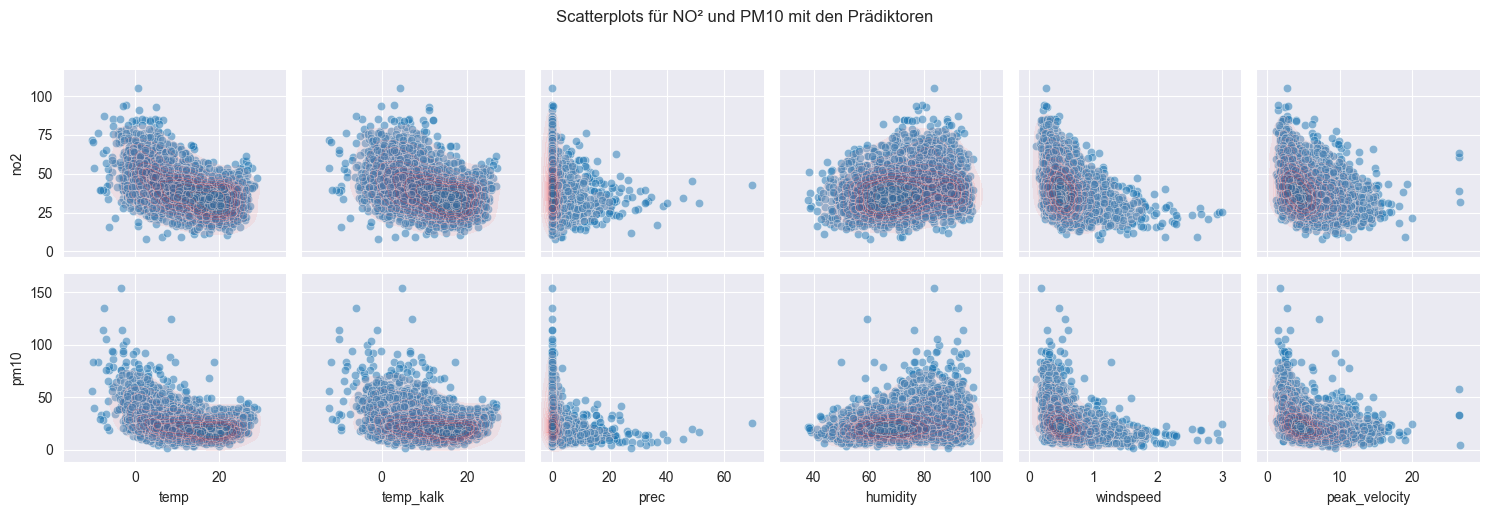

In [6]:
# c) Paarweise Scatterplots, um einen Eindruck der Zusammenhänge zu gewinnen
#   (ohne day_type, da kategorisch)
# Temperaturdaten von Kalkleiten hinzufügen
df_combined = pd.merge(
    df_graz,
    df_kalk[["temp"]].rename(columns={"temp": "temp_kalk"}),
    left_index=True,
    right_index=True,
    how="inner"
)

# Fokus-Spalten: NO₂ und PM10 als Zielvariablen, Prädiktoren als X-Achsen
cols_focus = ["no2", "pm10", "temp", "temp_kalk", "prec", "humidity", "windspeed", "peak_velocity"]

# Daten für die Visualisierung extrahieren
df_focus = df_combined[cols_focus]

# PairGrid: Nur Scatterplots für NO₂ und PM10 mit Prädiktoren
g = sns.PairGrid(df_focus, y_vars=["no2", "pm10"], x_vars=["temp", "temp_kalk", "prec", "humidity", "windspeed", "peak_velocity"])
g.map(sns.scatterplot, alpha=0.5)  # Scatterplot
g.map(sns.kdeplot, color="red", fill=True, alpha=0.2)  # Dichtekurven

# Titel und Layout anpassen
g.fig.suptitle("Scatterplots für NO² und PM10 mit den Prädiktoren", y=1.02)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)  # Platz für den Titel

# Plot speichern und anzeigen
plt.savefig("scatter_no2_pm10_prädiktoren.png")
plt.show()

# Interessant erscheinen hier vorallem folgende Zusammenhänge:
# 1) NO² und pm10 mit Temperatur (nicht linear)
# 2) NO² mit pm10 (linear) soll aber nicht in betracht gezogen werden.
# 3) pm10 und prec (Niederschlag in l/m²), könnte auf eine hyperbolische Beziehung hindeuten
# 4) windspeed und pm10 scheinen negativ zu korrelieren.


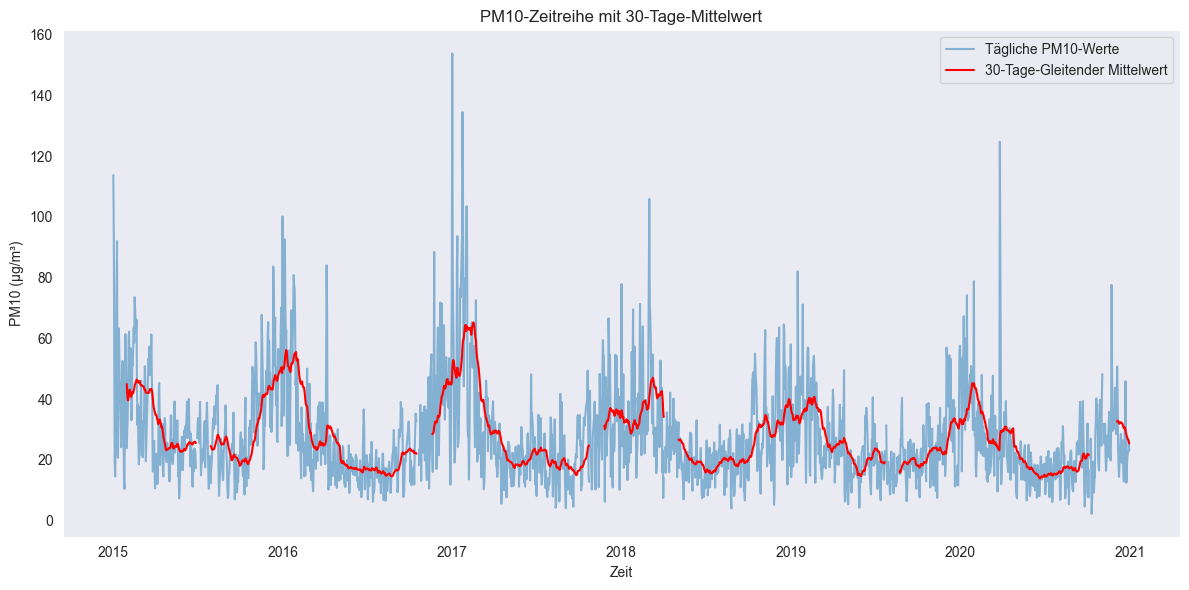

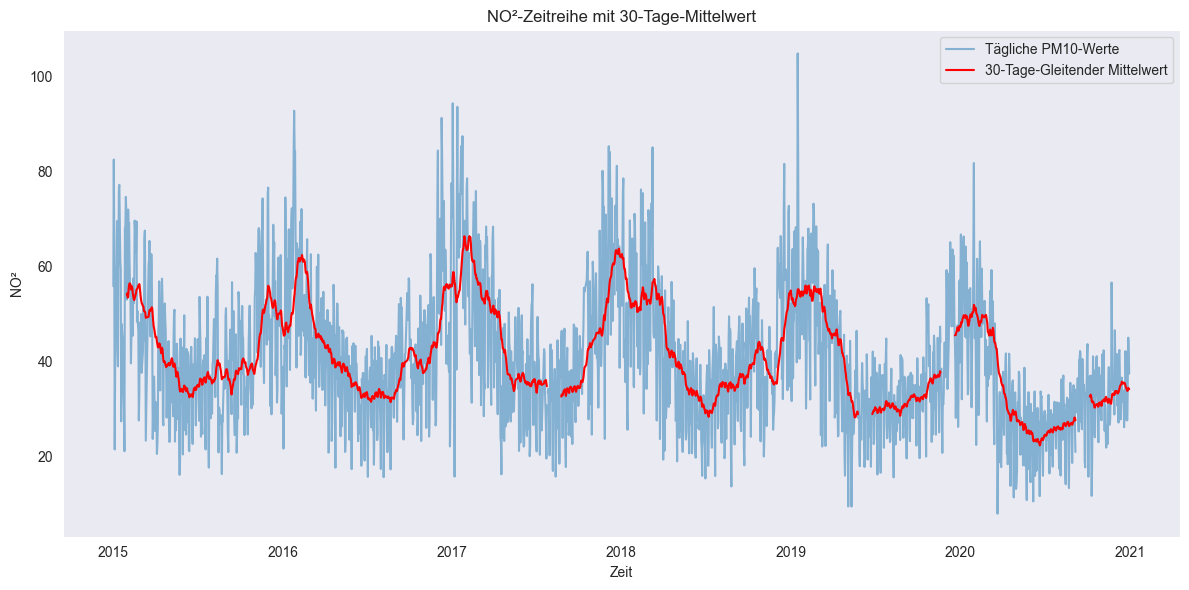

In [7]:
# Plotten von Feinstaub und NO² über die Zeit um Muster/Trends zu erkennen:
# Gleitender Durchschnitt
df_graz["pm10_rolling"] = df_graz["pm10"].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_graz.index, df_graz["pm10"], label="Tägliche PM10-Werte", alpha=0.5)
plt.plot(df_graz.index, df_graz["pm10_rolling"], label="30-Tage-Gleitender Mittelwert", color="red")
plt.xlabel("Zeit")
plt.ylabel("PM10 (µg/m³)")
plt.title("PM10-Zeitreihe mit 30-Tage-Mittelwert")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

df_graz["no2_rolling"] = df_graz["no2"].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_graz.index, df_graz["no2"], label="Tägliche PM10-Werte", alpha=0.5)
plt.plot(df_graz.index, df_graz["no2_rolling"], label="30-Tage-Gleitender Mittelwert", color="red")
plt.xlabel("Zeit")
plt.ylabel("NO²")
plt.title("NO²-Zeitreihe mit 30-Tage-Mittelwert")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# Deutlich wird hier ein Phasischer Verlauf vermutlich korrelierend mit den Wintermonaten (Heiz Saison, mehr Autoverkehr etc.)
# Zu diesem Zweck verwenden wir eine Heatmap um diese Vermutung zu Untersuchen.

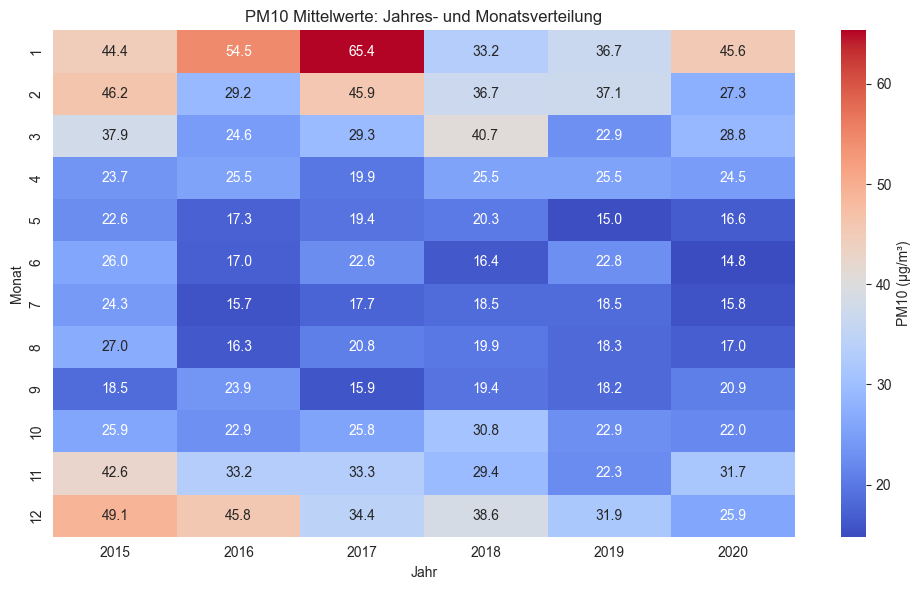

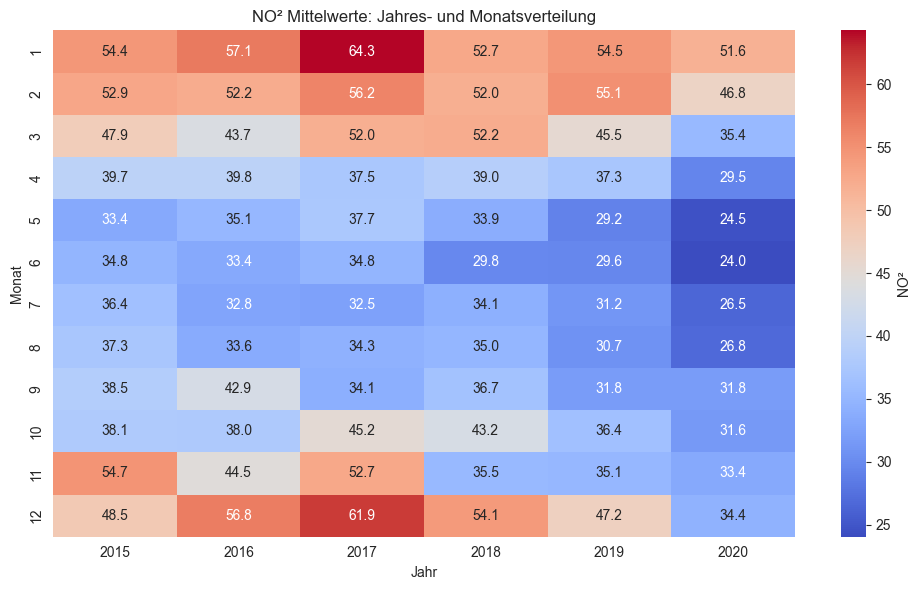

In [8]:
# Monat und Jahr aus dem Index extrahieren
df_graz["year"] = df_graz.index.year
df_graz["month"] = df_graz.index.month

# Pivot-Tabelle erstellen
heatmap_data = df_graz.pivot_table(
    values="pm10", index="month", columns="year", aggfunc="mean"
)

# Heatmap plotten
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "PM10 (µg/m³)"})
plt.title("PM10 Mittelwerte: Jahres- und Monatsverteilung")
plt.xlabel("Jahr")
plt.ylabel("Monat")
plt.tight_layout()
plt.show()

heatmap_data = df_graz.pivot_table(
    values="no2", index="month", columns="year", aggfunc="mean"
)

# Heatmap plotten
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "NO²"})
plt.title("NO² Mittelwerte: Jahres- und Monatsverteilung")
plt.xlabel("Jahr")
plt.ylabel("Monat")
plt.tight_layout()
plt.show()

# Es ist eindeutig ersichtlich, dass um die Wintermonate (11. - 2.) Die Belastung am höchsten ist.

In [9]:
###############################################################################
# 2) Erstes Modell für pm10 und no2 (2015-2019) - Lineare Regression
###############################################################################

# a) Train/Test Split: 2015-2019 Trainingsdaten, 2020 Testdaten
train_graz_df = df_graz.loc[(df_graz.index.year >= 2015) & (df_graz.index.year <= 2019)].copy()
test_graz_df = df_graz.loc[(df_graz.index.year == 2020)].copy()

train_kalk_df = df_kalk.loc[(df_kalk.index.year >= 2015) & (df_kalk.index.year <= 2019)].copy()
test_kalk_df = df_kalk.loc[(df_kalk.index.year == 2020)].copy()
# Mit den vielversprechenden Daten sieht unser Modell nicht besonders gut aus. (Adj. R-squared:	0.341)

In [10]:
regression_modell_no2 = smf.ols("no2 ~ temp + windspeed + prec", data=train_graz_df).fit()
regression_modell_no2.summary()
# Gleiches gilt hier bie NO²

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     347.9
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          6.57e-178
Time:                        08:36:15   Log-Likelihood:                -6882.3
No. Observations:                1792   AIC:                         1.377e+04
Df Residuals:                    1788   BIC:                         1.379e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.9702      0.603     97.759      0.000      57.787      60.153
temp          -0.7443      0.033    -22.757      0.000      -0.808      -0.680
windspeed    -12.4917      0.761    -16.420      0.000     -13.984     -11.000
prec          -0.2374      0.051     -4.628      0.000      -0.338      -0.137
==============================================================================
Omnibus:                       20.454   Durbin-Watson:                   0.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.875
Skew:                           0.263   Prob(JB):                     2.93e-05
Kurtosis:                       3.058   Cond. No.                         48.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# b) Daher versuchen wir die besten Parameter heraus zu finden. Dazu definieren wir eine Methode die iterativ jede mögliche Kombination aller Variablen zueinander ausprobiert (mit und ohne Wurzeltransformation und mit und ohne hyperbolischer Funktion) um zu ermitteln welche Kombination von Variablen uns den besten R² Adj. liefert.

def find_best_model_with_anova(data, response, predictors):
    """
    Findet das beste OLS-Regressionsmodell für eine gegebene Zielvariable und Prädiktoren,
    unter Berücksichtigung sowohl der ursprünglichen als auch der transformierten Prädiktoren
    (I(1/(var + 1)) und sqrt(var + 1)). Führt anschließend einen ANOVA-Test durch, um die
    Signifikanz des Modells zu bewerten.

    Parameters:
    - data: pandas DataFrame, die die Daten enthält.
    - response: string, Name der Zielvariable (z.B. "pm10").
    - predictors: list of strings, Namen der Prädiktorvariablen (z.B. ["temp", "prec", "windspeed"]).

    Returns:
    - best_formula: string, die Formel des besten Modells.
    - best_model: statsmodels RegressionResultsWrapper, das gefittete beste Modell.
    - best_lambda: float, der Lambda-Wert der Box-Cox-Transformation.
    - predicted_original: pandas Series, vorhergesagte Zielwerte auf der Originalskala.
    - anova_results: pandas DataFrame, Ergebnisse des ANOVA-Tests.
    """
    # Ignoriere SettingWithCopyWarning
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

    best_adj_r2 = -np.inf
    best_formula = None
    best_model = None
    best_lambda = None
    predicted_original = None
    anova_results = None

    # Schritt 1: Fehlende Werte in der Zielvariable und den Prädiktoren entfernen und eine Kopie erstellen
    data = data.dropna(subset=[response] + predictors).copy()

    # Schritt 2: Sicherstellen, dass die Zielvariable positiv ist für Box-Cox
    if (data[response] <= 0).any():
        shift = 1 - data[response].min()  # Verschiebung, um alle Werte > 0 zu machen
        data[response] = data[response] + shift
    else:
        shift = 0

    # Schritt 3: Box-Cox-Transformation der Zielvariable durchführen
    boxcox_transformed, lambda_boxcox = boxcox(data[response])
    data['boxcox_response'] = boxcox_transformed
    print(f"Optimaler Lambda-Wert für Box-Cox: {lambda_boxcox}")

    # Schritt 4: Definiere Transformationen
    # Für jede Prädiktorvariable: 'none', 'inv', 'sqrt'
    transformation_options = ['none', 'inv', 'sqrt']

    # Schritt 5: Iteration über alle möglichen nicht-leeren Teilmengen der Prädiktoren
    for k in range(1, len(predictors) + 1):
        for subset in itertools.combinations(predictors, k):
            # Für jede Teilmenge alle möglichen Transformationen durchgehen
            # Transformation pro Prädiktor: 'none', 'inv', 'sqrt'
            for transform_flags in itertools.product(transformation_options, repeat=k):
                terms = []
                valid = True
                for var, transform in zip(subset, transform_flags):
                    if transform == 'inv':
                        # Überprüfen, ob 1 / (var + 1) gültig ist (keine Division durch Null oder negative Werte)
                        if (data[var] + 1 <= 0).any():
                            valid = False
                            break
                        term = f"I(1 / ({var} + 1))"
                    elif transform == 'sqrt':
                        # Überprüfen, ob sqrt(var + 1) gültig ist (var + 1 >= 0)
                        if (data[var] + 1 < 0).any():
                            valid = False
                            break
                        term = f"I(np.sqrt({var} + 1))"
                    else:
                        term = var
                    terms.append(term)
                if not valid:
                    continue  # Überspringen, wenn die Transformation ungültig ist
                # Formel erstellen
                formula = f"boxcox_response ~ " + " + ".join(terms)
                try:
                    model = smf.ols(formula, data=data).fit()
                    adj_r2 = model.rsquared_adj
                    if adj_r2 > best_adj_r2:
                        best_adj_r2 = adj_r2
                        best_formula = formula
                        best_model = model
                        best_lambda = lambda_boxcox
                except Exception as e:
                    # Fehler beim Fitting des Modells behandeln
                    print(f"Fehler beim Fitten des Modells: {formula}. Fehler: {e}")
                    continue

    # Schritt 6: Wenn ein Bestmodell gefunden wurde, inverse Box-Cox-Transformation der Vorhersagen durchführen
    if best_model is not None:
        # Berechne die Vorhersagen auf der Box-Cox-Skala
        boxcox_fitted = best_model.fittedvalues
        # Inverse Box-Cox-Transformation
        if best_lambda != 0:
            inverse_transform = (boxcox_fitted * best_lambda + 1) ** (1 / best_lambda)
        else:
            inverse_transform = np.exp(boxcox_fitted)
        # Falls eine Verschiebung vorgenommen wurde, diese rückgängig machen
        if shift != 0:
            inverse_transform -= shift
        predicted_original = inverse_transform

        # Schritt 7: ANOVA-Test durchführen
        # Erstelle ein Nullmodell (nur Intercept)
        null_formula = f"boxcox_response ~ 1"
        null_model = smf.ols(null_formula, data=data).fit()

        # Führe ANOVA durch
        anova_results = anova_lm(null_model, best_model)
        print("\nANOVA Ergebnisse:")
        print(anova_results)
    else:
        print("Kein gültiges Modell gefunden.")
        return None, None, None, None, None

    return best_formula, best_model, best_lambda, predicted_original, anova_results

# Die Funktion find_best_model_with_anova gibt fünf Werte zurück:
#
# best_formula: Die Formel des besten Modells.
# best_model: Das gefittete Modellobjekt.
# best_lambda: Der optimale Lambda-Wert der Box-Cox-Transformation.
# predicted_original: Die vorhergesagten Werte auf der Originalskala.
# anova_results: Die Ergebnisse des ANOVA-Tests.


response_variable = "pm10"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity"]

best_formula, best_model, best_lambda, predicted_original, anova_results = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula)
print(best_model.summary())
# Das schaut schon besser aus! Wir konnten unser R² adj. auf 0.412 erhöhen und gleichzeitig AIC auf 1855 reduzieren, ist aber immer noch weit weg von gut.

Optimaler Lambda-Wert für Box-Cox: -0.002884805674753925

ANOVA Ergebnisse:
   df_resid         ssr  df_diff    ss_diff          F         Pr(>F)
0    1783.0  500.094996      0.0        NaN        NaN            NaN
1    1778.0  293.466565      5.0  206.62843  250.37629  8.468732e-203
Bestes Modell-Formel: boxcox_response ~ temp + I(1 / (prec + 1)) + humidity + I(1 / (windspeed + 1)) + I(1 / (peak_velocity + 1))
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     250.4
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          8.47e-203
Time:                        08:36:19   Log-Likelihood:                -921.46
No. Observations:                1784   AIC:                             1855.
Df Residuals:                  

In [12]:
response_variable = "no2"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity"]

best_formula2, best_model2, best_lambda2, predicted_original2, anova_results2 = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula2)
print(best_model2.summary())
# Auch hier haben wir mit unserer Methode zumindest ein besseres Modell finden können.

Optimaler Lambda-Wert für Box-Cox: 0.24371210636149118

ANOVA Ergebnisse:
   df_resid          ssr  df_diff     ss_diff           F         Pr(>F)
0    1791.0  1248.702148      0.0         NaN         NaN            NaN
1    1786.0   725.617246      5.0  523.084902  257.499292  1.628753e-207
Bestes Modell-Formel: boxcox_response ~ temp + I(1 / (prec + 1)) + humidity + I(np.sqrt(windspeed + 1)) + peak_velocity
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     257.5
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          1.63e-207
Time:                        08:36:22   Log-Likelihood:                -1732.7
No. Observations:                1792   AIC:                             3477.
Df Residuals:                    1

In [61]:
###############################################################################
# 3) Inversion
###############################################################################

# a) Berechnung der Temperaturdifferenz
train_graz_df['temp_diff'] = train_graz_df['temp'] - train_kalk_df['temp']
test_graz_df['temp_diff'] = test_graz_df['temp'] - test_graz_df['temp']

# b) Berechnung mittels neuer Variable:
response_variable = "no2"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity", "temp_diff"]
best_formula3, best_model3, best_lambda3, predicted_original3, anova_results3 = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula3)
print(best_model3.summary())
# Mittels unserer neuen Variable konnten wir unser Modell nochmals verbessern!

Optimaler Lambda-Wert für Box-Cox: 0.24814732005445359

ANOVA Ergebnisse:
   df_resid          ssr  df_diff    ss_diff           F         Pr(>F)
0    1769.0  1274.680839      0.0        NaN         NaN            NaN
1    1763.0   646.592819      6.0  628.08802  285.424136  1.370491e-255
Bestes Modell-Formel: boxcox_response ~ temp + I(np.sqrt(prec + 1)) + humidity + windspeed + I(1 / (peak_velocity + 1)) + temp_diff
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     285.4
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          1.37e-255
Time:                        09:05:47   Log-Likelihood:                -1620.3
No. Observations:                1770   AIC:                             3255.
Df Residuals:            

In [62]:
response_variable = "pm10"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity", "temp_diff"]
best_formula4, best_model4, best_lambda4, predicted_original4, anova_results4 = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula4)
print(best_model4.summary())

# Auch beim Feinstaub zeigt sich eine Verbesserung von R² Adjusted. Wir nähern uns einem guten Modell ;-)

Optimaler Lambda-Wert für Box-Cox: 0.010953459397803608

ANOVA Ergebnisse:
   df_resid         ssr  df_diff     ss_diff           F         Pr(>F)
0    1761.0  537.619659      0.0         NaN         NaN            NaN
1    1755.0  282.578117      6.0  255.041541  263.996559  6.644105e-241
Bestes Modell-Formel: boxcox_response ~ temp + I(1 / (prec + 1)) + humidity + windspeed + I(1 / (peak_velocity + 1)) + temp_diff
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     264.0
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          6.64e-241
Time:                        09:05:56   Log-Likelihood:                -887.72
No. Observations:                1762   AIC:                             1789.
Df Residuals:              

In [66]:
###############################################################################
# 4) Noch mehr Variablen Lagged values
###############################################################################

# Neue Variablen erstellen

# 1. Frost-Variable: 1 wenn Temperatur < 0°C, sonst 0
train_graz_df['frost'] = (train_graz_df['temp'] < 0).astype(int)
test_graz_df['frost'] = (test_graz_df['temp'] < 0).astype(int)

# 2. Inversions-Variable: 1 wenn Temperaturdifferenz < 0°C, sonst 0
train_graz_df['inversion'] = (train_graz_df['temp_diff'] < 0).astype(int)
test_graz_df['inversion'] = (test_graz_df['temp_diff'] < 0).astype(int)

# 3. Starke Wind-Variable: 1 wenn Windspeed > 0.6, sonst 0
# Stellen Sie sicher, dass die Spalte 'windspeed' korrekt benannt ist
train_graz_df['strong_wind'] = (train_graz_df['windspeed'] > 0.6).astype(int)
test_graz_df['strong_wind'] = (test_graz_df['windspeed'] > 0.6).astype(int)

# 4. Jahres-Variable: Extrahieren des Jahres aus dem Index
train_graz_df['year'] = train_graz_df.index.year
test_graz_df['year'] = test_graz_df.index.year

# Überprüfen der ersten paar Zeilen, um sicherzustellen, dass die neuen Variablen korrekt erstellt wurden
print(train_graz_df[['temp', 'temp_diff', 'frost', 'inversion', 'windspeed', 'strong_wind', 'year']].head())
print(test_graz_df[['temp', 'temp_diff', 'frost', 'inversion', 'windspeed', 'strong_wind', 'year']].head())

# Aktualisieren der Liste der Prädiktorvariablen
response_variable = "no2"
predictor_variables_train = ["temp", "prec", "humidity", "windspeed", "peak_velocity", "temp_diff"]

# Hinzufügen neuer Variablen zu den Prädiktoren
predictor_variables_extended_train = predictor_variables_train + ['frost', 'inversion', 'strong_wind', 'year']



                temp  temp_diff  frost  inversion  windspeed  strong_wind  \
DateTime                                                                    
2015-01-04  3.666447   2.535817      0          0   1.427332            1   
2015-01-05  2.146478   2.823136      0          0   1.079748            1   
2015-01-06  1.424162   1.509792      0          0   0.489554            0   
2015-01-07 -1.472883   2.215455      1          0   0.450311            0   
2015-01-08 -2.365285  -0.311312      1          1   0.368521            0   

            year  
DateTime          
2015-01-04  2015  
2015-01-05  2015  
2015-01-06  2015  
2015-01-07  2015  
2015-01-08  2015  
                temp  temp_diff  frost  inversion  windspeed  strong_wind  \
DateTime                                                                    
2020-01-04  1.596898        0.0      0          0   0.355738            0   
2020-01-05  3.094656        0.0      0          0   1.143790            1   
2020-01-06 -1.74979

In [67]:
# Berechnung, Cave braucht sehr lang zum berechnen (auf meinem Laptop ca. 45 min)
best_formula_extended, best_model_extended, best_lambda_extended, predicted_original_extended, anova_results_extended = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables_extended_train
)

print("Bestes Modell-Formel mit erweiterten Variablen:", best_formula_extended)
print(best_model_extended.summary())
# Auch mit diesen Variablen schaffen wir nur noch eine kleine Verbesserung auf 0.499 R² adj.

Optimaler Lambda-Wert für Box-Cox: 0.24814732005445359


KeyboardInterrupt: 

In [68]:
regression_modell_no2 = smf.ols("no2 ~ temp + I(np.sqrt(prec + 1)) + humidity + I(np.sqrt(windspeed + 1)) + I(1 / (peak_velocity + 1)) + temp_diff + I(np.sqrt(frost + 1)) + inversion + year", data=train_graz_df).fit()
regression_modell_no2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     217.6
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          2.70e-278
Time:                        09:07:14   Log-Likelihood:                -6542.6
No. Observations:                1770   AIC:                         1.311e+04
Df Residuals:                    1760   BIC:                         1.316e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1130.2577    335.969      3.364      0.001     471.318    1789.197
temp                          -0.7232      0.039    -18.690      0.000      -0.799      -0.647
I(np.sqrt(prec + 1))           0.5813      0.315      1.844      0.065      -0.037       1.200
humidity                      -0.3284      0.030    -10.888      0.000      -0.388      -0.269
I(np.sqrt(windspeed + 1))    -41.5445      2.934    -14.160      0.000     -47.299     -35.790
I(1 / (peak_velocity + 1))   -18.8856      5.009     -3.770      0.000     -28.710      -9.062
temp_diff                     -2.2759      0.221    -10.293      0.000      -2.710      -1.842
I(np.sqrt(frost + 1))          9.1688      2.335      3.927      0.000       4.590      13.748
inversion                      3.3714      1.069      3.153      0.002       1.274       5.469
year                          -0.4996      0.167     -3.000      0.003      -0.826      -0.173
==============================================================================
Omnibus:                        0.175   Durbin-Watson:                   1.103
Prob(Omnibus):                  0.916   Jarque-Bera (JB):                0.226
Skew:                          -0.017   Prob(JB):                        0.893
Kurtosis:                       2.956   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
regression_modell_no2 = smf.ols("pm10 ~ temp + I(np.sqrt(prec + 1)) + humidity + I(np.sqrt(windspeed + 1)) + I(1 / (peak_velocity + 1)) + temp_diff + I(np.sqrt(frost + 1)) + inversion + year", data=train_graz_df).fit()
regression_modell_no2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pm10   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     221.7
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          9.88e-282
Time:                        09:07:15   Log-Likelihood:                -6718.5
No. Observations:                1762   AIC:                         1.346e+04
Df Residuals:                    1752   BIC:                         1.351e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   2247.0028    378.517      5.936      0.000    1504.611    2989.395
temp                          -0.2664      0.044     -6.111      0.000      -0.352      -0.181
I(np.sqrt(prec + 1))          -1.8519      0.357     -5.189      0.000      -2.552      -1.152
humidity                      -0.0711      0.034     -2.094      0.036      -0.138      -0.005
I(np.sqrt(windspeed + 1))     -7.7255      3.327     -2.322      0.020     -14.251      -1.200
I(1 / (peak_velocity + 1))    34.4104      5.639      6.102      0.000      23.350      45.471
temp_diff                     -2.9009      0.249    -11.660      0.000      -3.389      -2.413
I(np.sqrt(frost + 1))         36.5923      2.625     13.940      0.000      31.444      41.741
inversion                      0.4814      1.202      0.401      0.689      -1.875       2.838
year                          -1.1098      0.188     -5.915      0.000      -1.478      -0.742
==============================================================================
Omnibus:                      544.696   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2824.440
Skew:                           1.361   Prob(JB):                         0.00
Kurtosis:                       8.574   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
# d) Hinzufügen von Lagged Variables

def add_lagged_features(df, features, lags):
    for feature in features:
        for lag in lags:
            lag_col_name = f"{feature}_lag{lag}"
            df[lag_col_name] = df[feature].shift(lag)
    return df

features_to_lag = ['temp', 'prec', 'humidity', 'windspeed', 'peak_velocity']
lags = [1, 2, 3]  # Lag1, Lag2, Lag3

combined_df = pd.concat([train_graz_df, test_graz_df])

combined_df = add_lagged_features(combined_df, features_to_lag, lags)

# Wiederaufteilen der Daten in Trainings- und Testsets
train_graz_df = combined_df.loc[(combined_df.index.year >= 2015) & (combined_df.index.year <= 2019)].copy()
test_graz_df = combined_df.loc[(combined_df.index.year == 2020)].copy()

# e) Umgang mit fehlenden Werten nach dem Shift
max_lag = max(lags)
train_graz_df = train_graz_df.iloc[max_lag:]
test_graz_df = test_graz_df.iloc[max_lag:]

# f) Definieren der Prädiktorvariablen mit Transformationen und Lagged Variables
response_variable = "pm10"

transformations = [
    "I(np.sqrt(prec + 1))",
    # "I(np.sqrt(windspeed + 1))",
    "I(1 / (peak_velocity + 1))",
    "I(np.sqrt(frost + 1))"
]

# Basis-Prädiktoren
base_predictors = ['temp', 'humidity', 'temp_diff', 'inversion', 'year']

lagged_vars = [f"{feature}_lag{lag}" for feature in ['temp', 'humidity', 'peak_velocity'] for lag in [1, 2, 3]]
all_predictors = transformations + base_predictors + lagged_vars

# Definieren der Variablen, die entfernt werden sollen
vars_to_remove = ['windspeed', 'peak_velocity_lag2', 'peak_velocity_lag3', 'temp_lag1', 'temp_lag2', 'humidity_lag2', 'humidity', 'inversion']

# Generieren des neuen Formelstrings
def generate_formula(response, predictors, remove_vars=[]):
    predictors_filtered = [var for var in predictors if var not in remove_vars]
    formula = f"{response} ~ " + " + ".join(predictors_filtered)
    return formula

new_formula = generate_formula("pm10", all_predictors, remove_vars=vars_to_remove)
print("Neuer Formelstring:", new_formula)

# Fit des neuen Modells
regression_modell_pm10_neu = smf.ols(new_formula, data=train_graz_df).fit()
print(regression_modell_pm10_neu.summary())

# Noch weitere Verbesserung aber wir entfernen die Variablen mit den höchsten p-values was uns zu einer R² von immerhin 0.578 führt

Neuer Formelstring: pm10 ~ I(np.sqrt(prec + 1)) + I(1 / (peak_velocity + 1)) + I(np.sqrt(frost + 1)) + temp + temp_diff + year + temp_lag3 + humidity_lag1 + humidity_lag3 + peak_velocity_lag1
                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     240.4
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          1.23e-319
Time:                        09:07:16   Log-Likelihood:                -6616.0
No. Observations:                1759   AIC:                         1.325e+04
Df Residuals:                    1748   BIC:                         1.331e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  

In [71]:
regression_modell_pm10_neu = smf.ols(new_formula, data=test_graz_df).fit()
print(regression_modell_pm10_neu.summary())

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     31.02
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           1.48e-36
Time:                        09:07:24   Log-Likelihood:                -1328.0
No. Observations:                 356   AIC:                             2674.
Df Residuals:                     347   BIC:                             2709.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [72]:
# Speichern der Formel
formula = (
    "pm10 ~ I(np.sqrt(prec + 1)) + "
    "I(1 / (peak_velocity + 1)) + "
    "I(np.sqrt(frost + 1)) + "
    "temp + temp_diff + year + "
    "temp_lag3 + humidity_lag1 + humidity_lag3 + peak_velocity_lag1"
)

# Funktion zur Vorbereitung des DataFrame
def prepare_model_dataframe(df):
    columns_needed = [
        'pm10',
        'prec',
        'peak_velocity',
        'frost',
        'temp',
        'temp_diff',
        'year',
        'temp_lag3',
        'humidity_lag1',
        'humidity_lag3',
        'peak_velocity_lag1'
    ]
    model_df = df[columns_needed].copy()
    model_df = model_df.dropna()
    return model_df

# Vorbereitung des DataFrame
model_df = prepare_model_dataframe(train_graz_df)

# Durchführung der OLS-Regression
regression_modell_pm10 = smf.ols(formula, data=model_df).fit()

# Ausgabe der Modellzusammenfassung
print(regression_modell_pm10.summary())

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     240.4
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          1.23e-319
Time:                        09:07:25   Log-Likelihood:                -6616.0
No. Observations:                1759   AIC:                         1.325e+04
Df Residuals:                    1748   BIC:                         1.331e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

=== PM10 Modellvergleich ===
R² Original: 0.579
R² Wurzeltransformation: 0.596
AIC Original: 13253.9
AIC Wurzeltransformation: 4572.9

=== NO2 Modellvergleich ===
R² Original: 0.511
R² Wurzeltransformation: 0.490
AIC Original: 13143.1
AIC Wurzeltransformation: 4116.4


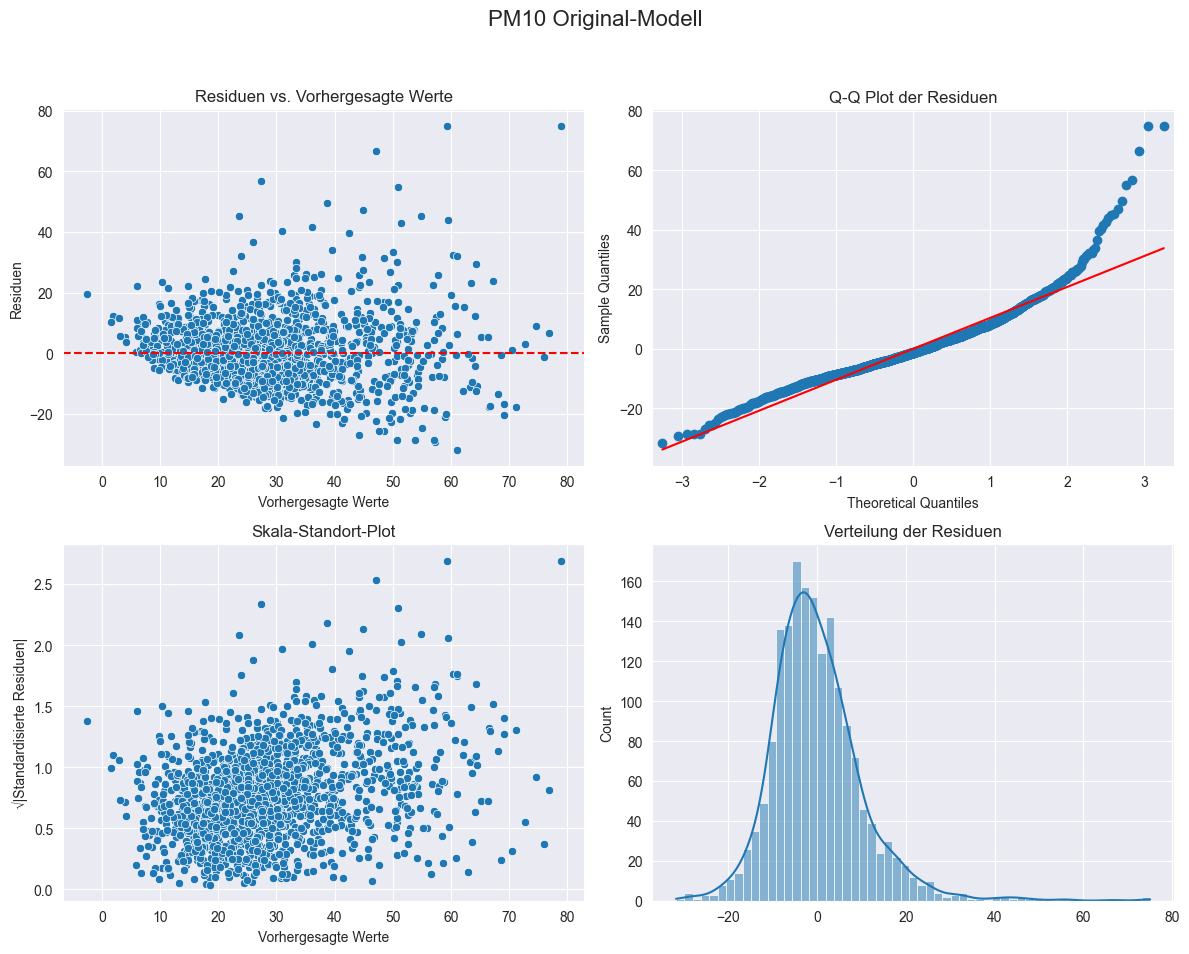

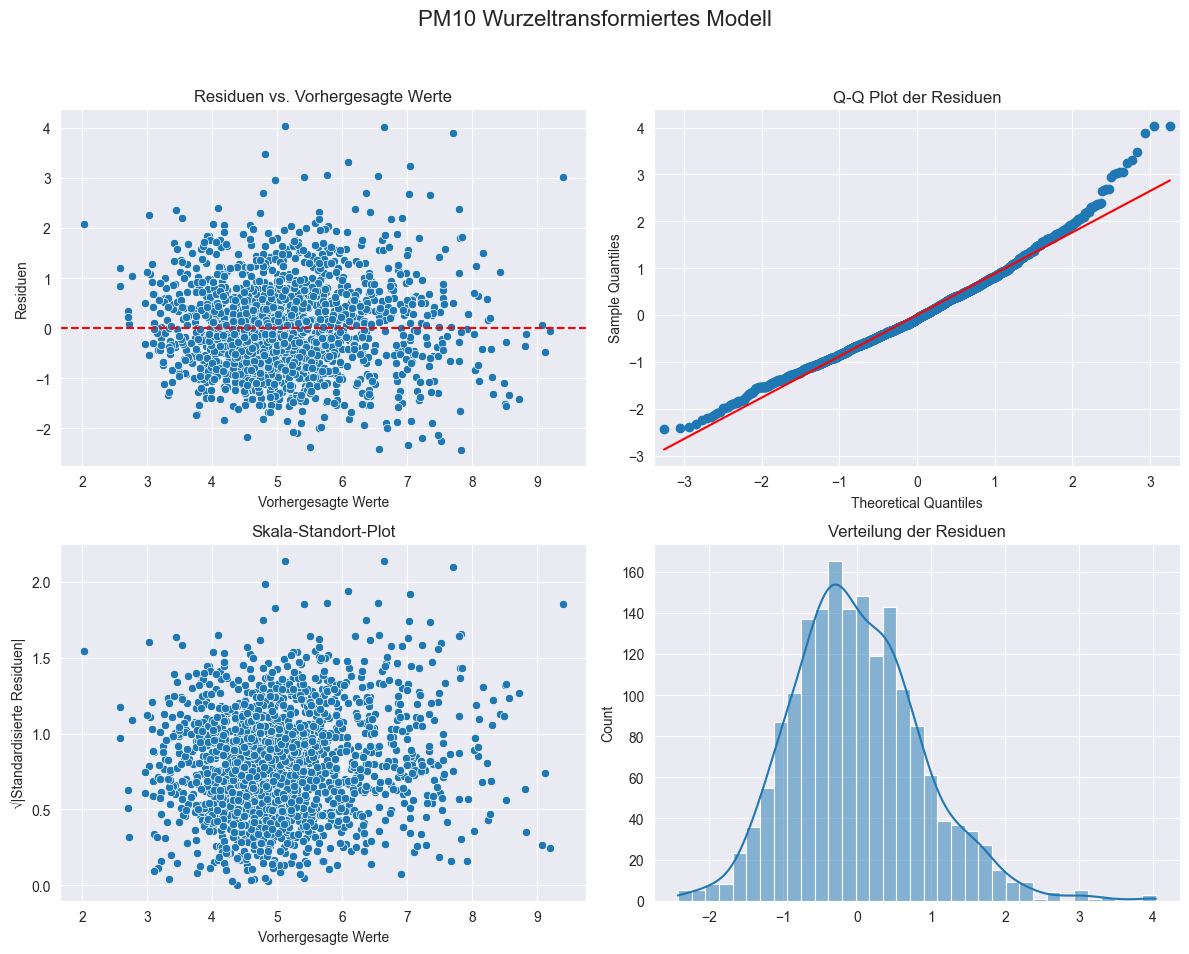

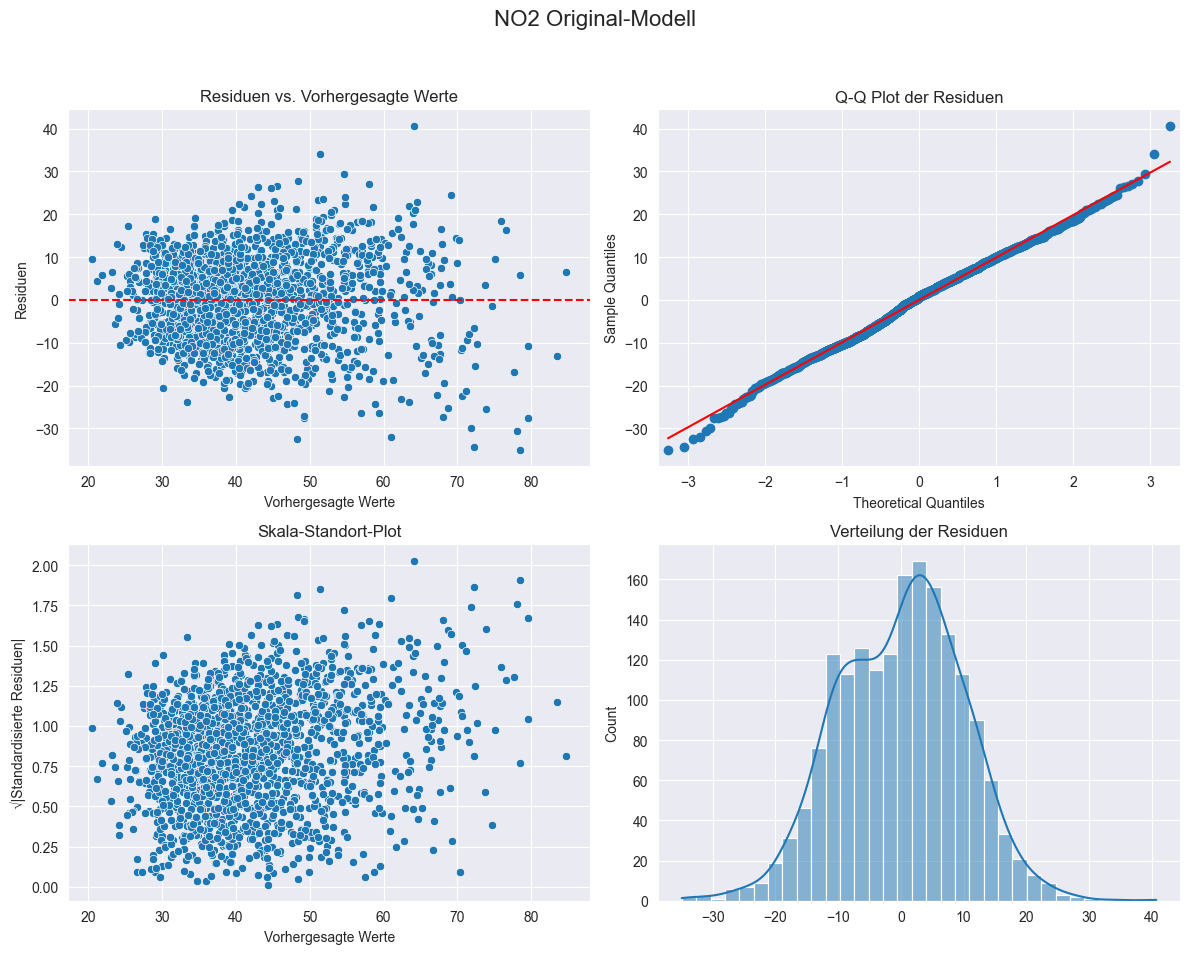

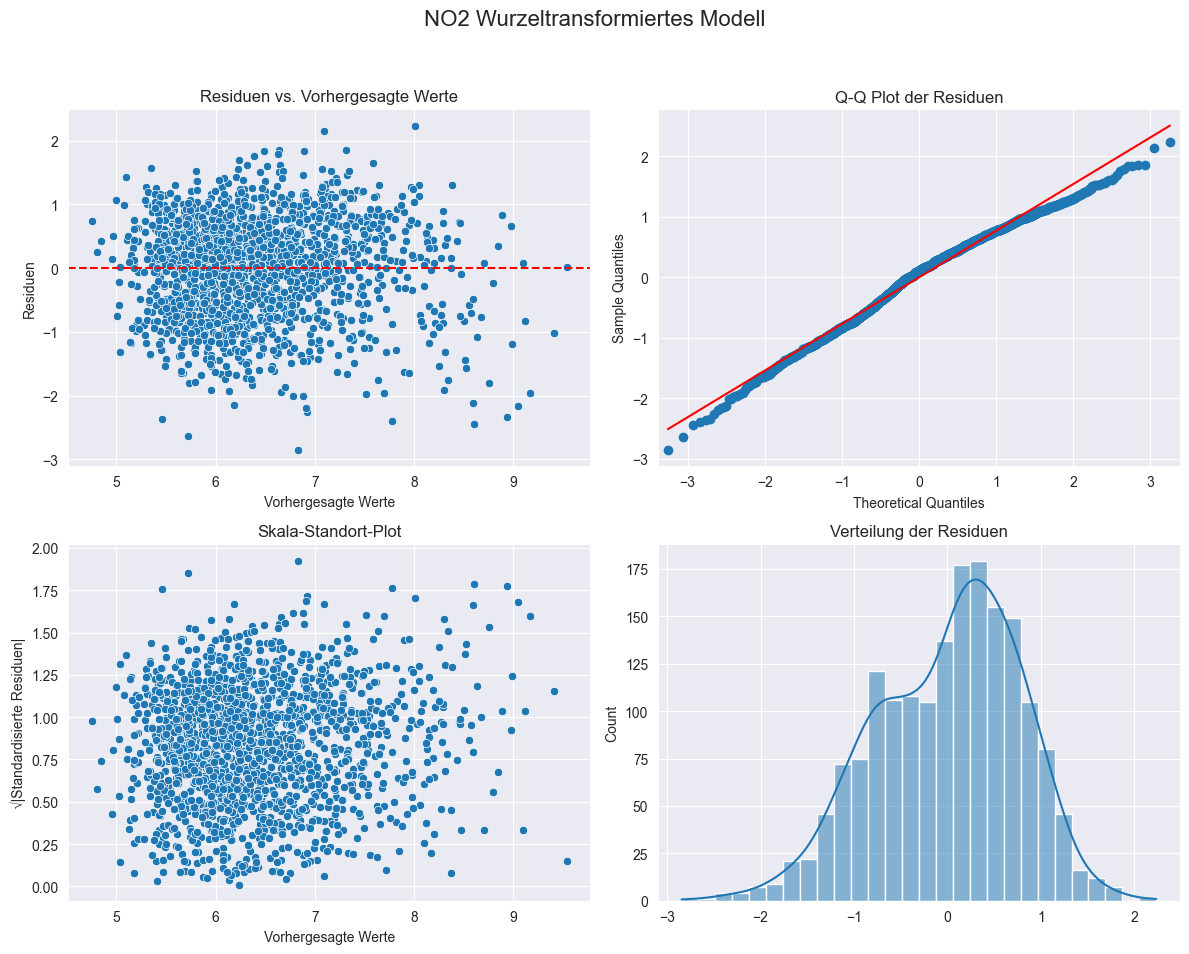


=== Shapiro-Wilk-Test der Residuen ===
PM10 Original: ShapiroResult(statistic=0.9239917993545532, pvalue=6.240523993103014e-29)
PM10 Wurzel: ShapiroResult(statistic=0.9838409423828125, pvalue=3.4741662129599005e-13)
NO2 Original: ShapiroResult(statistic=0.996626615524292, pvalue=0.0006290756282396615)
NO2 Wurzel: ShapiroResult(statistic=0.9874944090843201, pvalue=3.012155108672587e-11)


In [73]:
###############################################################################
# 5) Vergleich Model mit und ohne Wurzel
###############################################################################

def erstelle_modelle_mit_transformation(df, zielvariable, praediktoren):
    """Erstellt und vergleicht Modelle mit und ohne Wurzeltransformation"""

    # Original-Modell
    formel_original = f"{zielvariable} ~ " + " + ".join(praediktoren)
    modell_original = smf.ols(formel_original, data=df).fit()

    # Modell mit Wurzeltransformation der Zielvariable
    df = df.copy()  # Um das Original-DataFrame nicht zu verändern
    df[f'sqrt_{zielvariable}'] = np.sqrt(df[zielvariable])
    formel_wurzel = f"sqrt_{zielvariable} ~ " + " + ".join(praediktoren)
    modell_wurzel = smf.ols(formel_wurzel, data=df).fit()

    return modell_original, modell_wurzel

def erstelle_diagnostik_plots(modell, titel):
    """Erstellt diagnostische Plots für das Modell"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Residuen vs. Fitted
    sns.scatterplot(x=modell.fittedvalues, y=modell.resid, ax=ax1)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Vorhergesagte Werte')
    ax1.set_ylabel('Residuen')
    ax1.set_title('Residuen vs. Vorhergesagte Werte')

    # Q-Q Plot
    sm.qqplot(modell.resid, line='s', ax=ax2)
    ax2.set_title('Q-Q Plot der Residuen')

    # Skala-Standort-Plot (Scale-Location Plot)
    standardized_resid = np.sqrt(np.abs(modell.get_influence().resid_studentized_internal))
    sns.scatterplot(x=modell.fittedvalues, y=standardized_resid, ax=ax3)
    ax3.set_xlabel('Vorhergesagte Werte')
    ax3.set_ylabel('√|Standardisierte Residuen|')
    ax3.set_title('Skala-Standort-Plot')

    # Residuen-Verteilung
    sns.histplot(modell.resid, kde=True, ax=ax4)
    ax4.set_title('Verteilung der Residuen')

    plt.suptitle(titel, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

# Definieren der Prädiktorvariablen für PM10 und NO2
praediktoren_pm10 = [
    "I(np.sqrt(prec + 1))",
    "I(1 / (peak_velocity + 1))",
    "I(np.sqrt(frost + 1))",
    "temp",
    "temp_diff",
    "year",
    "temp_lag3",
    "humidity_lag1",
    "humidity_lag3",
    "peak_velocity_lag1"
]

praediktoren_no2 = praediktoren_pm10.copy()  # Falls die Prädiktoren für NO2 gleich sind; andernfalls anpassen

# Trainingsdaten vorbereiten (2015-2019)
mask_train = (train_graz_df.index.year >= 2015) & (train_graz_df.index.year <= 2019)
train_df = train_graz_df[mask_train].copy()

# Modelle für PM10
pm10_original, pm10_wurzel = erstelle_modelle_mit_transformation(train_df, 'pm10', praediktoren_pm10)

# Modelle für NO2
no2_original, no2_wurzel = erstelle_modelle_mit_transformation(train_df, 'no2', praediktoren_no2)

# Ergebnisse ausgeben
print("=== PM10 Modellvergleich ===")
print(f"R² Original: {pm10_original.rsquared:.3f}")
print(f"R² Wurzeltransformation: {pm10_wurzel.rsquared:.3f}")
print(f"AIC Original: {pm10_original.aic:.1f}")
print(f"AIC Wurzeltransformation: {pm10_wurzel.aic:.1f}")

print("\n=== NO2 Modellvergleich ===")
print(f"R² Original: {no2_original.rsquared:.3f}")
print(f"R² Wurzeltransformation: {no2_wurzel.rsquared:.3f}")
print(f"AIC Original: {no2_original.aic:.1f}")
print(f"AIC Wurzeltransformation: {no2_wurzel.aic:.1f}")

# Diagnostik-Plots erstellen
diagnostik_pm10_original = erstelle_diagnostik_plots(pm10_original, "PM10 Original-Modell")
diagnostik_pm10_wurzel = erstelle_diagnostik_plots(pm10_wurzel, "PM10 Wurzeltransformiertes Modell")
diagnostik_no2_original = erstelle_diagnostik_plots(no2_original, "NO2 Original-Modell")
diagnostik_no2_wurzel = erstelle_diagnostik_plots(no2_wurzel, "NO2 Wurzeltransformiertes Modell")

plt.show()

# Shapiro-Wilk-Test für Normalität der Residuen
print("\n=== Shapiro-Wilk-Test der Residuen ===")
print("PM10 Original:", stats.shapiro(pm10_original.resid))
print("PM10 Wurzel:", stats.shapiro(pm10_wurzel.resid))
print("NO2 Original:", stats.shapiro(no2_original.resid))
print("NO2 Wurzel:", stats.shapiro(no2_wurzel.resid))

                 pm10  predicted_pm10
DateTime                             
2020-01-07  53.685146       51.426015
2020-01-08  48.381897       51.462157
2020-01-09  67.240555       39.662370
2020-01-10  53.228900       40.577205
2020-01-11  40.723354       32.266088
2020-01-12  29.861776       32.686992
2020-01-13  59.957397       52.001839
2020-01-14  47.552048       49.647496
2020-01-15  46.133423       49.149398
2020-01-16  74.178720       36.523814


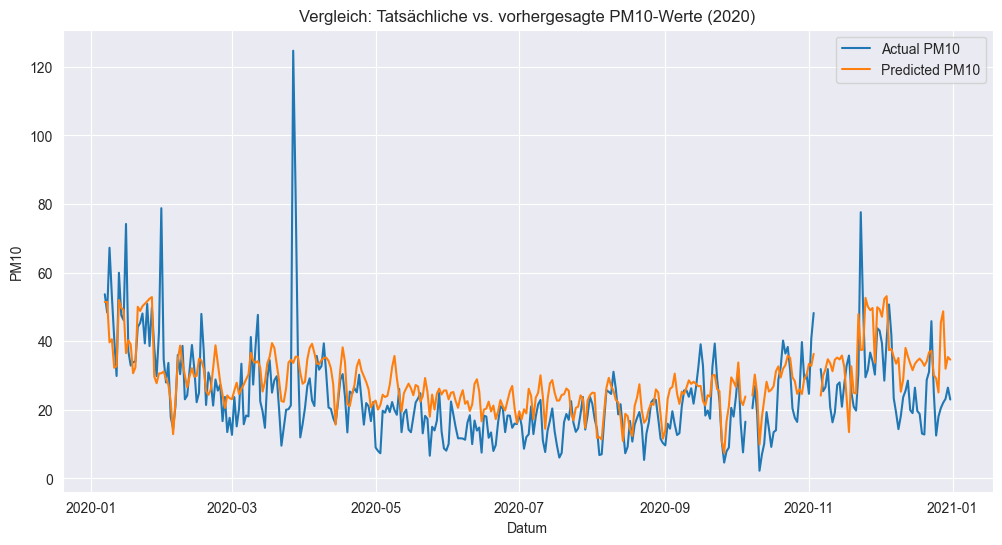

                  no2  predicted_pm10
DateTime                             
2020-01-07  64.128430       51.426015
2020-01-08  64.870260       51.462157
2020-01-09  66.336630       39.662370
2020-01-10  61.825607       40.577205
2020-01-11  51.574104       32.266088
2020-01-12  45.311913       32.686992
2020-01-13  64.232720       52.001839
2020-01-14  45.042190       49.647496
2020-01-15  47.643887       49.149398
2020-01-16  60.845080       36.523814


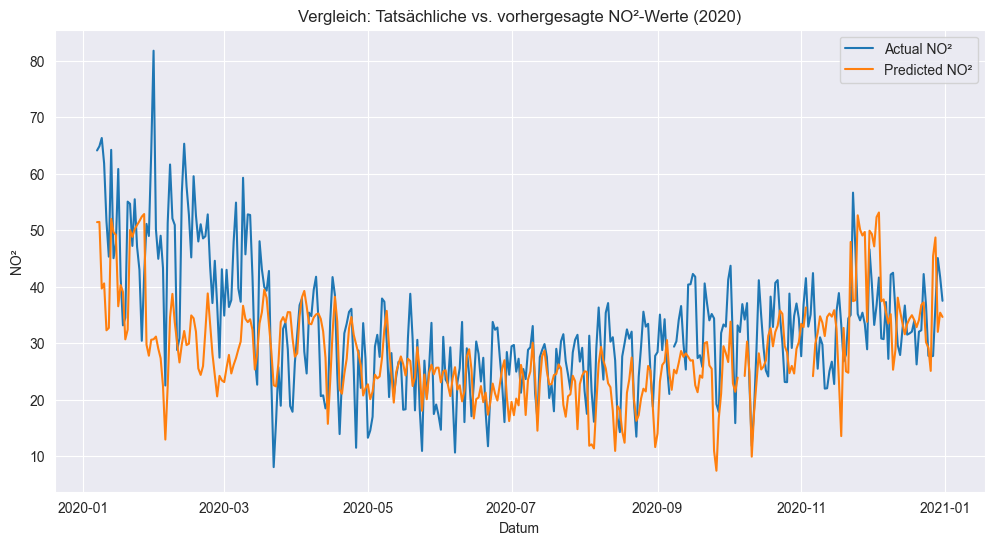

In [79]:
###############################################################################
# 6) Modell aus Punkt 5 wird für die Vorhersage 2020 benutzt
###############################################################################


# 1) Testdaten für 2020 vorbereiten
test_model_df = prepare_model_dataframe(test_graz_df)

# 2) Vorhersage für 2020 erzeugen
predictions_2020 = regression_modell_pm10.predict(test_model_df)

# 3) Ergebnisse anschauen
test_graz_df['predicted_pm10'] = predictions_2020
print(test_graz_df[['pm10', 'predicted_pm10']].head(10))

plt.figure(figsize=(12, 6))
plt.plot(test_graz_df.index, test_graz_df['pm10'], label='Actual PM10')
plt.plot(test_graz_df.index, test_graz_df['predicted_pm10'], label='Predicted PM10')
plt.title('Vergleich: Tatsächliche vs. vorhergesagte PM10-Werte (2020)')
plt.xlabel('Datum')
plt.ylabel('PM10')
plt.legend()
plt.grid(True)
plt.show()

test_graz_df['predicted_no2'] = predictions_2020
print(test_graz_df[['no2', 'predicted_pm10']].head(10))

plt.figure(figsize=(12, 6))
plt.plot(test_graz_df.index, test_graz_df['no2'], label='Actual NO²')
plt.plot(test_graz_df.index, test_graz_df['predicted_no2'], label='Predicted NO²')
plt.title('Vergleich: Tatsächliche vs. vorhergesagte NO²-Werte (2020)')
plt.xlabel('Datum')
plt.ylabel('NO²')
plt.legend()
plt.grid(True)
plt.show()

# Scheinbar ist unser modell nicht besonders gut in der Vorhersage der Daten. Es folgt zwar allgemein dem Trend extremwerte etc kann es aber so gut wie gar nicht vorhersagen.

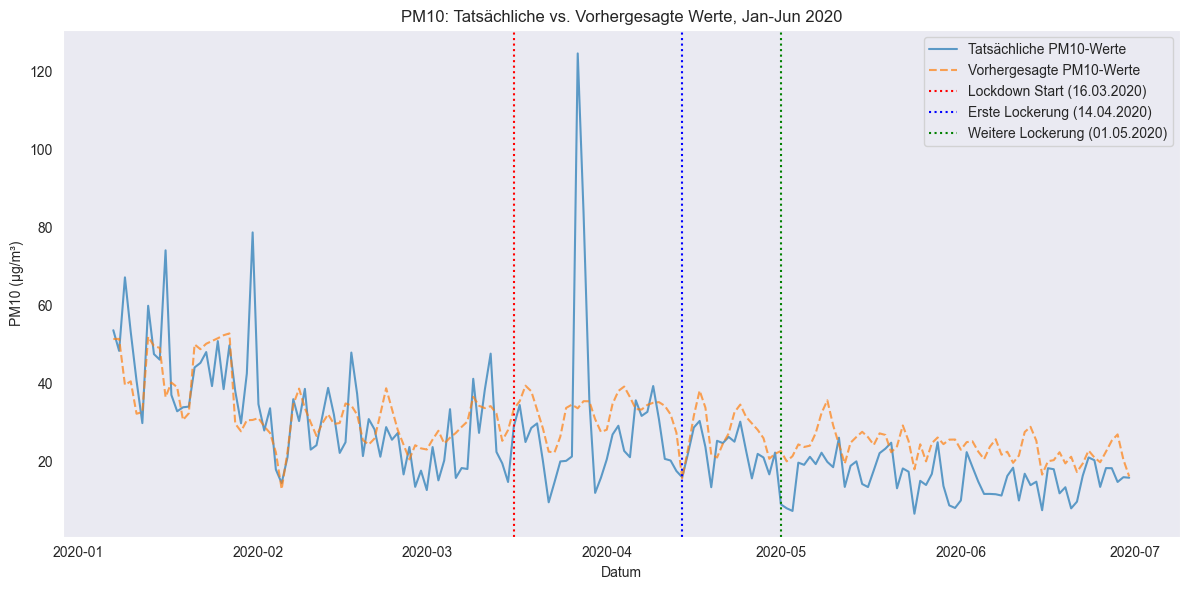

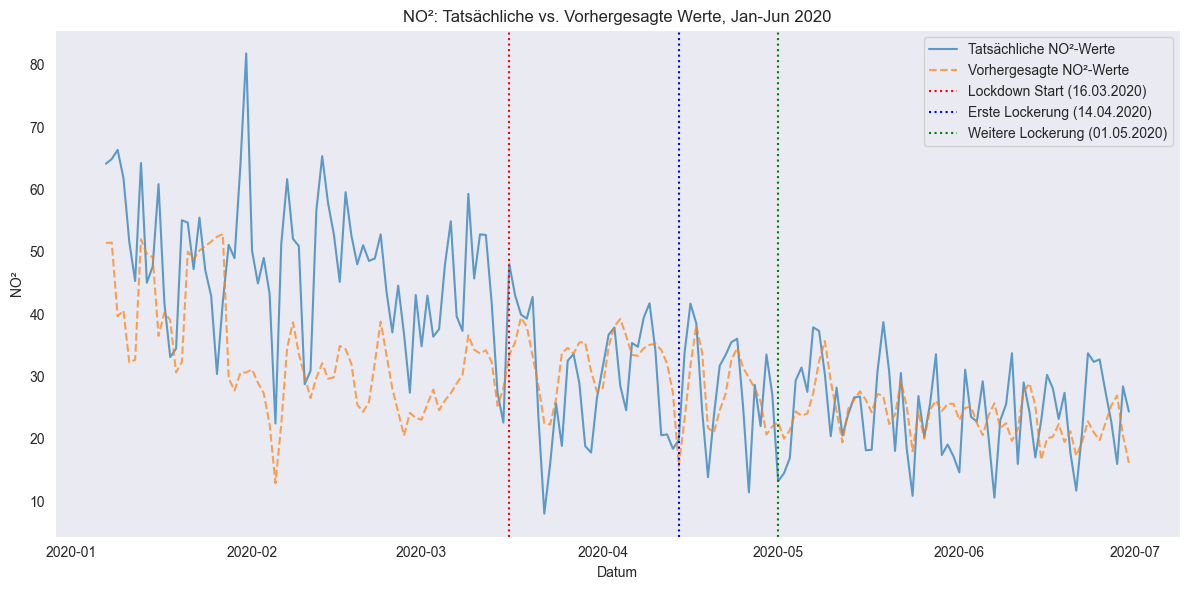

In [93]:
###############################################################################
# 7) Vergleichen der Vorhersage für 2020 mit den wahren Werten aus 2020
###############################################################################

# Nur Daten von Januar bis Juni 2020
test_df_6m = test_graz_df.loc["2020-01-01":"2020-06-30"].copy()

lockdown_start = pd.to_datetime("2020-03-16")
lockdown_easing1 = pd.to_datetime("2020-04-14")
lockdown_easing2 = pd.to_datetime("2020-05-01")
# lockdown_easing3 = pd.to_datetime("2020-11-17")


plt.figure(figsize=(12, 6))
plt.plot(test_df_6m.index, test_df_6m['pm10'], label='Tatsächliche PM10-Werte', alpha=0.7)
plt.plot(test_df_6m.index, test_df_6m['predicted_pm10'], 
         label='Vorhergesagte PM10-Werte', linestyle='--', alpha=0.7)

plt.axvline(lockdown_start, color='red', linestyle=':', label='Lockdown Start (16.03.2020)')
plt.axvline(lockdown_easing1, color='blue', linestyle=':', label='Erste Lockerung (14.04.2020)')
plt.axvline(lockdown_easing2, color='green', linestyle=':', label='Weitere Lockerung (01.05.2020)')
# plt.axvline(lockdown_easing3, color='purple', linestyle=':', label='Zweiter Lockdown (17.11.2020)')

plt.title("PM10: Tatsächliche vs. Vorhergesagte Werte, Jan-Jun 2020")
plt.xlabel("Datum")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_df_6m.index, test_df_6m['no2'], label='Tatsächliche NO²-Werte', alpha=0.7)
plt.plot(test_df_6m.index, test_df_6m['predicted_no2'],
         label='Vorhergesagte NO²-Werte', linestyle='--', alpha=0.7)

plt.axvline(lockdown_start, color='red', linestyle=':', label='Lockdown Start (16.03.2020)')
plt.axvline(lockdown_easing1, color='blue', linestyle=':', label='Erste Lockerung (14.04.2020)')
plt.axvline(lockdown_easing2, color='green', linestyle=':', label='Weitere Lockerung (01.05.2020)')
# plt.axvline(lockdown_easing3, color='purple', linestyle=':', label='Zweiter Lockdown (17.11.2020)')

plt.title("NO²: Tatsächliche vs. Vorhergesagte Werte, Jan-Jun 2020")
plt.xlabel("Datum")
plt.ylabel("NO²")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

###############################################################################
# 8) Letzte Gedanken:
###############################################################################

#
# Da unser Modell die Daten oft unterschätzt scheint der Beginn der COVID-Pandemie und der damit zusammenhängede Rückgang der Werte (bis auf einen Ausreißer) für unser Modell besonders gut zu sein.
# Man müsste wohl die Anzahl der Parameter deutlich reduzieren um unser Modell verbessern zu können. Jedoch blieb uns nicht annähnerng genug Zeit um das zu bewerkstelligen. Aber auch ein schlechtes Ergebnis ist ein Ergebnis. Für das Nächste mal würden wir versuchen ein (gut funktionierendes) Kreuzvalidierungsverfahren anstatt einer selbst geschriebenen Methode zu verwenden um das beste OLS-Modell zu ermitteln. Ich vermute dass hierin der Fehler liegt.